# Backtest benchmark - Julia

GARCH backtesting with Julia to test speed and accuracy.

In [66]:
# Load data - S&P500
using CSV;
price = CSV.read("index.csv");
y = diff(log.(price[:,1]));

### Backtesting for different estimation windows

In [67]:
# Set up backtest

using Statistics;
T = length(y);                         # number of obs for return y
p = 0.01;                              # probability
value = 1;                             # portfolio value
VaR = fill(NaN, T);                    # matrix for forecasts

In [71]:
# Backtest function

using Distributions, ARCHModels;

function backtest(WE)
    VaR = fill(NaN, T);
    for t in WE+1:T
        t1 = t - WE;                          # start of data window
        t2 = t - 1;                           # end of data window
        window = y[t1:t2];                    # data for estimation

        garch1_1 = fit(GARCH{1,1}, window; meanspec = NoIntercept);
        cond_vol = predict(garch1_1, :volatility);
        VaR[t]= -cond_vol * quantile(Normal(0,1),p) * value; # GARCH(1,1) 
    end
    return VaR
end

backtest (generic function with 2 methods)

In [70]:
# Benchmarking
using TimerOutputs;

const benchmark = TimerOutput()

N = 10 # Number of tests

for n in 1:N
    @timeit benchmark "WE: 1000" backtest(1000)
    @timeit benchmark "WE: 2000" backtest(2000)    
    @timeit benchmark "WE: 5000" backtest(5000)
end

benchmark

 ───────────────────────────────────────────────────────────────────
                            Time                   Allocations      
                    ──────────────────────   ───────────────────────
  Tot / % measured:       262s / 100%            57.8GiB / 100%     

 Section    ncalls     time   %tot     avg     alloc   %tot      avg
 ───────────────────────────────────────────────────────────────────
 WE: 2000       10     121s  46.4%   12.1s   24.8GiB  42.9%  2.48GiB
 WE: 1000       10    88.0s  33.6%   8.80s   20.3GiB  35.2%  2.03GiB
 WE: 5000       10    52.4s  20.0%   5.24s   12.7GiB  21.9%  1.27GiB
 ───────────────────────────────────────────────────────────────────

In [78]:
# Store results for WE = 2000
VaR_results = backtest(2000);

In [88]:
# Import Python data
python = CSV.read("python_backtest_results.csv"; header = false);
python = convert(Array, python[:,1]);

In [94]:
# Check difference
difference = VaR_results - python;

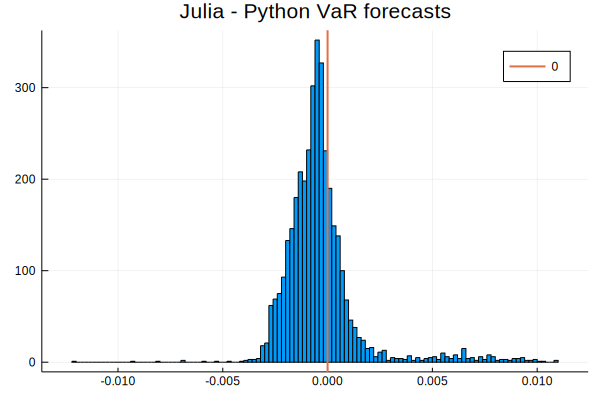

In [104]:
using Plots;
histogram(difference, title = "Julia - Python VaR forecasts", label = false)
vline!([0], linewidth = 2, label = "0") 